# Analysis

## Helper functions

In [15]:
# Function to swap 'lose' with 'win' and vice versa
def swap_lose_win(identifier):
    if 'lose' in identifier:
        return identifier.replace('lose', 'win')
    elif 'win' in identifier:
        return identifier.replace('win', 'lose')
    return identifier

## Data & Environment Preparation

In [31]:
# import libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# File names and directory of files
file_names = ["313578_daoo_flow_2024-05-21_08h32.44.710.csv",
              "995362_daoo_flow_2024-05-21_08h29.59.102.csv",]
directory = '/Users/anja/Desktop/data_mt/'

# Initialize an empty list to store DataFrames
dfs = []

for file_name in file_names:
    # Construct the full file path
    file_path = os.path.join(directory, file_name)
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path, usecols=['expStart', # date time
                                           'block_name', # which testing block?
                                           'participant', # particpant id
                                           'value_distribution', # identifies chance trials
                                           'value_amount', # what was the actual amount for balance update
                                           'identifier_chooser_owner_value', # identifies condition set --> must be corrected
                                           'yc_resp.keys', # which color box was chosen?
                                           'owner_confirm_2.rt', # reaction time of interest
                                           'owner_confirm.rt', # reaction time of interest
                                           'too_slow.started', # sort out trial when filled 
                                           'wrong_answer.started' # sort out trial when filled 
                                           ])
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenating files together
combined_df = pd.concat(dfs, ignore_index=True)

In [8]:
# Display head
print(combined_df.head())

           block_name  value_distribution  value_amount  \
0  the practice block                90.0          -2.0   
1  the practice block                90.0           4.0   
2  the practice block                90.0          -2.0   
3  the practice block                90.0           4.0   
4        Block 1 of 3                90.0          -2.0   

  identifier_chooser_owner_value yc_resp.keys  owner_confirm_2.rt  \
0                            NaN            k            0.552634   
1                            NaN            k            0.466795   
2                            NaN          NaN                 NaN   
3                            NaN          NaN                 NaN   
4                 cozmo_you_lose          NaN                 NaN   

   owner_confirm.rt  too_slow.started  wrong_answer.started  participant  \
0               NaN               NaN                   NaN     313578.0   
1               NaN               NaN                   NaN     313578.0   
2 

In [9]:
# Summary Stats for combined dataframe
print(df.describe())

       value_distribution  value_amount  owner_confirm_2.rt  owner_confirm.rt  \
count           20.000000     20.000000           11.000000          9.000000   
mean            86.000000      1.300000            0.654588          0.652928   
std             17.888544      3.062507            0.060933          0.091398   
min             10.000000     -2.000000            0.571349          0.527287   
25%             90.000000     -2.000000            0.607924          0.589306   
50%             90.000000      4.000000            0.661824          0.665550   
75%             90.000000      4.000000            0.692923          0.684467   
max             90.000000      4.000000            0.765939          0.829201   

       wrong_answer.started  too_slow.started  participant  
count              1.000000          2.000000         20.0  
mean              13.258566        102.339453     995362.0  
std                     NaN         29.593153          0.0  
min               13.25856

## Data Cleaning

In [22]:
# Clean from rows where response was too slow or wrong
cleaned_df = combined_df[combined_df['too_slow.started'].isna() & combined_df['wrong_answer.started'].isna()]

# Clean from practice trials
cleaned_df = cleaned_df[cleaned_df['block_name'] != 'the practice block']

# Correct identifier for random samples (20%) in the original cleaned_df
cleaned_df.loc[cleaned_df['value_distribution'] == 10, 'identifier_chooser_owner_value'] = cleaned_df.loc[cleaned_df['value_distribution'] == 10, 'identifier_chooser_owner_value'].apply(swap_lose_win)

In [24]:
# Create one reaction time column from both existing columns
cleaned_df['reaction_time'] = cleaned_df['owner_confirm_2.rt'].fillna(cleaned_df['owner_confirm.rt'])

In [25]:
print(cleaned_df.head())

      block_name  value_distribution  value_amount  \
4   Block 1 of 3                90.0          -2.0   
5   Block 1 of 3                90.0           4.0   
7   Block 1 of 3                90.0          -2.0   
9   Block 2 of 3                90.0           4.0   
10  Block 2 of 3                90.0           4.0   

   identifier_chooser_owner_value yc_resp.keys  owner_confirm_2.rt  \
4                  cozmo_you_lose          NaN                 NaN   
5                   cozmo_you_win          NaN                 NaN   
7                    you_you_lose            k            0.514589   
9                 cozmo_cozmo_win          NaN                 NaN   
10                    you_you_win            g            0.452512   

    owner_confirm.rt  too_slow.started  wrong_answer.started  participant  \
4           0.513968               NaN                   NaN     313578.0   
5           0.690786               NaN                   NaN     313578.0   
7                NaN   

In [27]:
print(cleaned_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 4 to 40
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   block_name                      25 non-null     object 
 1   value_distribution              25 non-null     float64
 2   value_amount                    25 non-null     float64
 3   identifier_chooser_owner_value  25 non-null     object 
 4   yc_resp.keys                    13 non-null     object 
 5   owner_confirm_2.rt              13 non-null     float64
 6   owner_confirm.rt                12 non-null     float64
 7   too_slow.started                0 non-null      float64
 8   wrong_answer.started            0 non-null      float64
 9   participant                     25 non-null     float64
 10  expStart                        25 non-null     object 
 11  reaction_time                   25 non-null     float64
dtypes: float64(8), object(4)
memory usage: 2.7+

## Analysis

In [ ]:
# Mean age, handedness, gender?

In [ ]:
# How many trials per particpant do we have? How many got sorted out in total? 

# How many trials per condition group?

In [ ]:
# Normal distribution of reaction time? Any outliers?

<Axes: xlabel='identifier_chooser_owner_value', ylabel='reaction_time'>

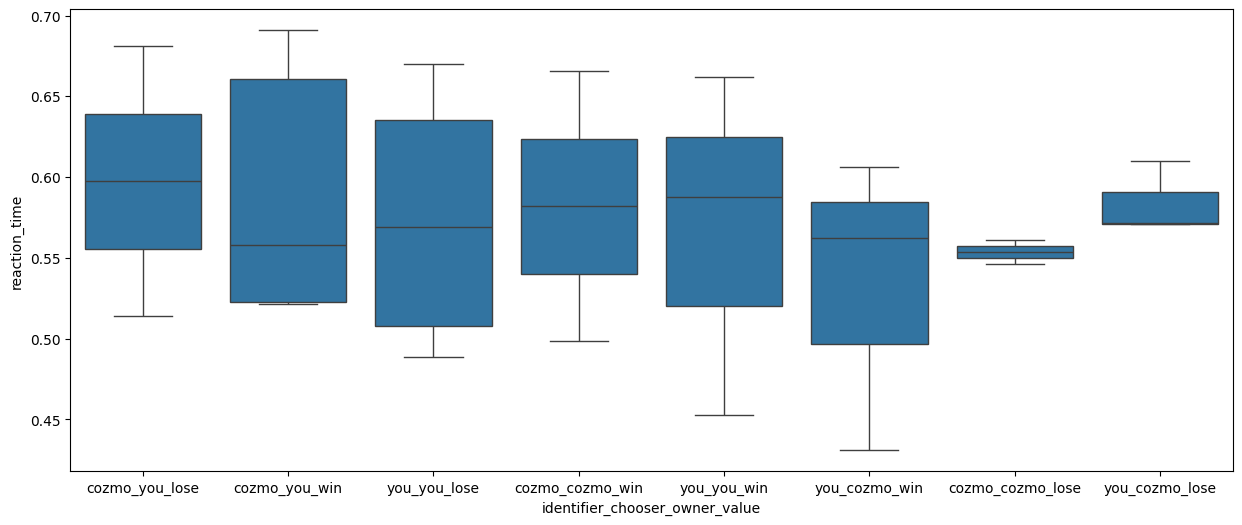

In [34]:
# Reaction time per condition group #TODO:change to violin plot when more data is available
plt.figure(figsize=(15, 6)) 
sns.boxplot( x=cleaned_df["identifier_chooser_owner_value"], y=cleaned_df["reaction_time"] )

In [ ]:
# how does reaction time develope over time? learing effects? do get people faster? 

In [ ]:
# do people prefer one choice? i mean by side? 